<a href="https://colab.research.google.com/github/Abel-Lagonell/Data-Mining/blob/main/Homework04_Abel_Lagonell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import dmba
from dmba import printTermDocumentMatrix

import sklearn.feature_extraction.text as text
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk import word_tokenize
from nltk.stem.snowball import EnglishStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# Question 1

The, laptop, was, difficult, to, set, up, ,, and, 

difficult, to, connect, to, the, WIFI, ., I, would, go, 

back, to, using, the, previous, laptop, except, it, no, longer, 

charges, ., -------------------------------------



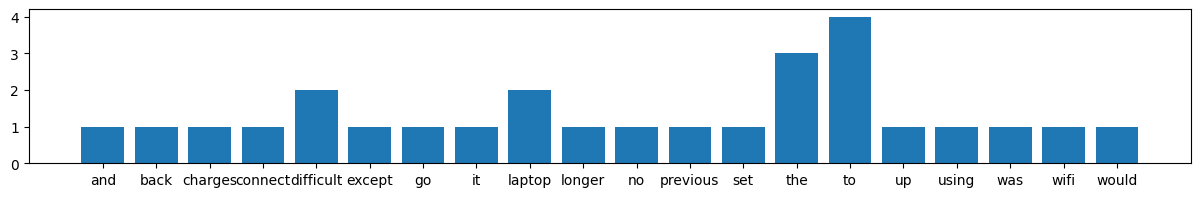

-------------------------------------



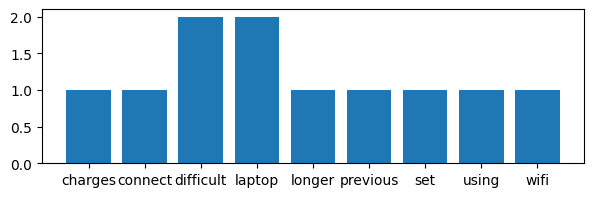

-------------------------------------



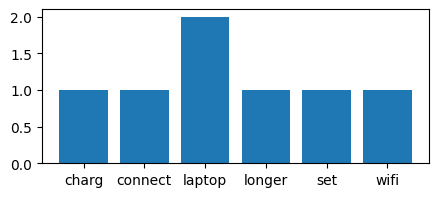

-------------------------------------

{'neg': 0.288, 'neu': 0.712, 'pos': 0.0, 'compound': -0.8074}


In [66]:
def plot_word_freq(vector, count, width=10):
    plt.figure(figsize=(width, 2))
    plt.bar(vector.get_feature_names_out(), np.ravel(count.sum(axis=0)))
    plt.show()

sample_text = "The laptop was difficult to set up, and difficult to connect to the WIFI. I would go back to using the previous laptop except it no longer charges."

#A
word_tokens = nltk.word_tokenize(sample_text)
for i, word in enumerate(word_tokens):
    if i%10 == 9: print('\n')
    print(word, end=', ')
print('-------------------------------------\n')
#B: Determine and plot the word frequency for the sample text.
count_vector = text.CountVectorizer()
count = count_vector.fit_transform([sample_text])
plot_word_freq(count_vector, count, width=15)
print('-------------------------------------\n')
#C
count_vector = text.CountVectorizer(stop_words='english')
count = count_vector.fit_transform([sample_text])
plot_word_freq(count_vector, count, width=7)
print('-------------------------------------\n')
#D
class LemmaTokenizer(object):
    def __init__(self):
        self.stemmer = EnglishStemmer()
        self.stopWords = ENGLISH_STOP_WORDS
        self.nouns = ['NN', 'NNS', 'NNP', 'NNPS']

    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in word_tokenize(doc)
                if t.isalpha() and t not in self.stopWords and nltk.pos_tag([t])[0][1] in self.nouns]

count_vector = text.CountVectorizer(tokenizer=LemmaTokenizer())
count = count_vector.fit_transform([sample_text])
plot_word_freq(count_vector, count, width=5)
print('-------------------------------------\n')
#E
sentiment = SentimentIntensityAnalyzer()
print(sentiment.polarity_scores(sample_text))

# Question 2

In [82]:
sample_text = r"""Thanks John!<br /><br /><font size=”3”>
&quot;Illustrations and demos will be
provided for students to work through on
their own&quot;</font>.
Do we need that to finish project? If yes,
where to find the illustration and demos?
Thanks for your help.\<img title=”smile”
alt=”smile” src=”\url{http://lms.statistics.com/pix/smartpix.php/statistics_com_1/s/smiley.gif}” \>
<br /> <br />
"""

# A
tokens = word_tokenize(sample_text)
non_words = [word for word in tokens if not word.isalpha()]
for i, word in enumerate(non_words):
    if i%11 == 10: print('\n')
    print(word, end='  ')
print('-------------------------------------\n')
# B
# We can remove all html tokens such as <, >, alt=, we can also remove anything between angle brackets
# C
# Words that we want are Demos, provided, project, help, illustration, find
# D
# Bag of words just get the different words and lose the bigger picture meaning of the actual text.

!  <  /  >  <  /  >  <  size=  ”  

3  ”  >  &  ;  &  ;  <  /font  >  .  

?  ,  ?  help.\  <  title=  ”  ”  alt=  ”  ”  

src=  ”  \url  {  :  //lms.statistics.com/pix/smartpix.php/statistics_com_1/s/smiley.gif  }  ”  \  >  <  

/  >  <  /  >  